In [2]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import array
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM

from google.colab import files
uploaded = files.upload()

Saving viettri_quality.csv to viettri_quality.csv


In [ ]:
# Function to smooth data
def smoothed(data, window_size=5):
    forecast_smoothed = data.rolling(window=window_size).mean()
    forecast_smoothed_interpolated = forecast_smoothed.interpolate()
    forecast_smoothed_filled = forecast_smoothed_interpolated.fillna(method='bfill')
    return forecast_smoothed_filled

# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('viettri_quality.csv')
df0=df.reset_index()['pm25']
print(df0.shape)

# Làm mượt dữ liệu
df1 = smoothed(df0)

# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
print(df1.shape)

(1920,)
(1920, 1)


In [ ]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

print(train_size)
print(test_size)
print(train_data.shape)
print(test_data.shape)

1344
576
(1344, 1)
(576, 1)


In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----29   Y=30
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

#6. Reshape into X=t,t+1,t+2..t+30 and Y=t+30

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(ytest.shape)

(1313, 30)
(1313,)
(545, 30)
(545,)


In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print(X_train.shape)
print(X_test.shape)

(1313, 30, 1)
(545, 30, 1)


In [ ]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(30,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 7s 54ms/step - loss: 0.0283
Epoch 2/100
21/21 [==============================] - 1s 56ms/step - loss: 0.0135
Epoch 3/100
21/21 [==============================] - 1s 54ms/step - loss: 0.0133
Epoch 4/100
21/21 [==============================] - 1s 55ms/step - loss: 0.0126
Epoch 5/100
21/21 [==============================] - 1s 55ms/step - loss: 0.0117
Epoch 6/100
21/21 [==============================] - 1s 54ms/step - loss: 0.0112
Epoch 7/100
21/21 [==============================] - 1s 54ms/step - loss: 0.0106
Epoch 8/100
21/21 [==============================] - 2s 79ms/step - loss: 0.0097
Epoch 9/100
21/21 [==============================] - 2s 85ms/step - loss: 0.0088
Epoch 10/100
21/21 [==============================] - 2s 76ms/step - loss: 0.0076
Epoch 11/100
21/21 [==============================] - 1s 54ms/step - loss: 0.0063
Epoch 12/100
21/21 [==============================] - 1s 53ms/step - loss: 0.0051
Epoch 13/100
21/21 [=====

In [ ]:
# 10. Dự báo dữ liệu test,
train_predict=model.predict(X_train)
y_pred=model.predict(test_data.reshape(test_data.shape[0],test_data.shape[1] , 1))


18/18 [==============================] - 1s 2ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

print(test_data.shape)
print(y_pred.shape)

(576, 1)
(576, 1)


In [ ]:
ytest=scaler.inverse_transform(test_data)

# Làm mượt dự đoán\
y_pred = smoothed(pd.Series(y_pred.flatten())).values.reshape(-1, 1)

# 12. Đánh giá mô hình
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

test_mae = np.mean(abs(y_pred - ytest))
print('Testing MAE:', test_mae)

test_mape = np.mean(np.abs(ytest - y_pred)/np.abs(ytest))*100
print('Testing MAPE:', test_mape)

Testing RMSE: 28.890244268119442
Testing MAE: 24.952085335055987
Testing MAPE: 52.05675749787129


In [ ]:
x_input=test_data[30:].reshape(1,-1)
x_input.shape

(1, 546)

In [ ]:
# temp_input=list(x_input)
# temp_input=temp_input[0].tolist()

# from numpy import array

# lst_output=[]
# n_steps=516
# i=0
# while(i<90):
#     print(f"Starting iteration {i}, len(temp_input): {len(temp_input)}")
#     if(len(temp_input)>516):
#         #print(temp_input)
#         x_input=np.array(temp_input[1:])
#         #print("{} day input {}".format(i,x_input))
#         x_input=x_input.reshape(1,-1)
#         x_input = x_input.reshape((1, n_steps, 1))
#         #print(x_input)
#         yhat = model.predict(x_input, verbose=0)
#         print("{} day output {}".format(i,yhat))
#         temp_input.extend(yhat[0].tolist())
#         temp_input=temp_input[1:]
#         #print(temp_input)
#         lst_output.extend(yhat.tolist())
#         i=i+1
#     else:
#         x_input = x_input.reshape((1, n_steps,1))
#         yhat = model.predict(x_input, verbose=0)
#         print(yhat[0])
#         temp_input.extend(yhat[0].tolist())
#         print(len(temp_input))
#         lst_output.extend(yhat.tolist())
#         i=i+1
# print(f"Completed {i} iterations")

In [ ]:
# 13. Dự báo 90 ngày tiếp theo
x_input=test_data[30:].reshape(1,-1)
print(x_input.shape)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=546
i=0
while i < 90:
    #print(f"Starting iteration {i}, len(temp_input): {len(temp_input)}")
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
    else:
        x_input = np.array(temp_input)
        x_input = x_input.reshape((1, n_steps, 1))

    yhat = model.predict(x_input, verbose=0)
    #print(f"{i + 1} day output {yhat}")
    temp_input.extend(yhat[0].tolist())
    lst_output.extend(yhat.tolist())
    i += 1

(1, 546)


In [ ]:
# print(x_input.shape)
# print(test_data.shape)
# print(y_pred.shape)

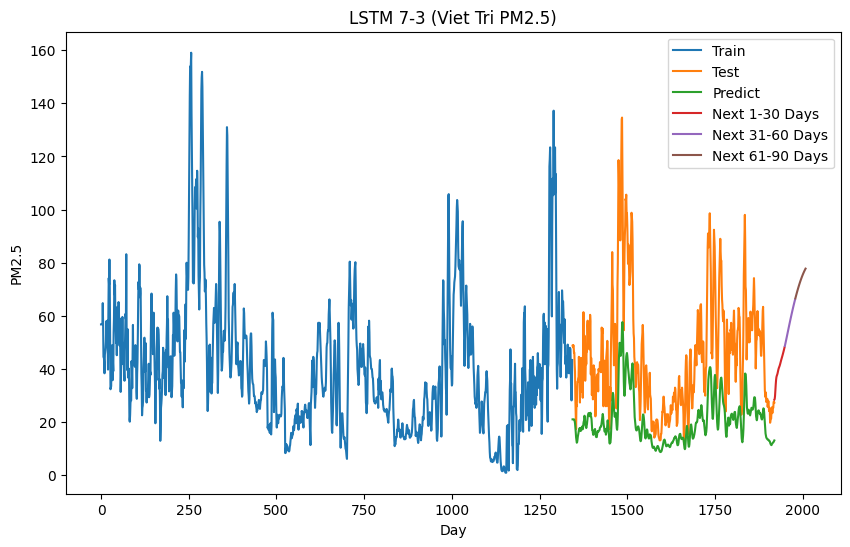

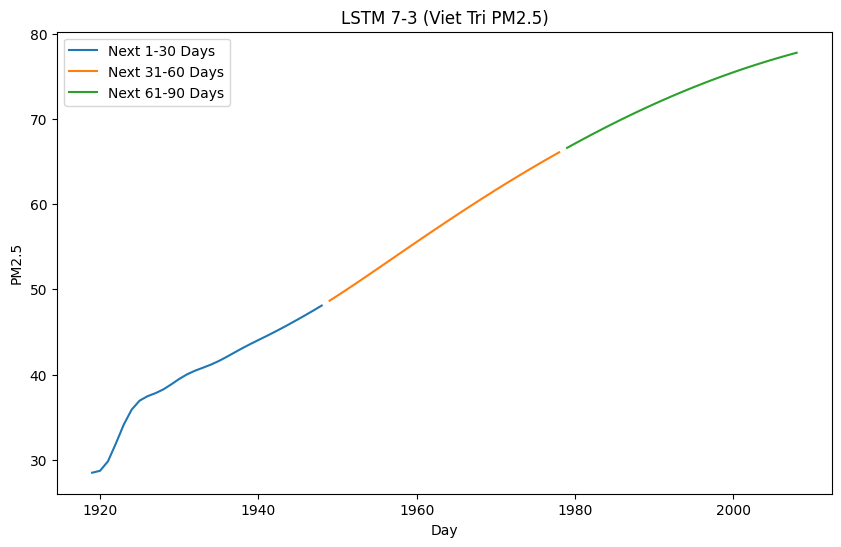

In [ ]:
# 14.Vẽ hình
plt.figure(figsize=(10, 6))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[60:90]))
plt.legend(['Train','Test','Predict','Next 1-30 Days', 'Next 31-60 Days', 'Next 61-90 Days'])
plt.title('LSTM 7-3 (Viet Tri PM2.5)')
plt.xlabel('Day')
plt.ylabel('PM2.5')
plt.show()

# Dự đoán 90 ngày tiếp theo
plt.figure(figsize=(10, 6))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[60:90]))
plt.legend(['Next 1-30 Days', 'Next 31-60 Days', 'Next 61-90 Days'])
plt.title('LSTM 7-3 (Viet Tri PM2.5)')
plt.xlabel('Day')
plt.ylabel('PM2.5')
plt.show()

In [ ]:
print(scaler.inverse_transform(lst_output))

[[28.47963634]
 [28.70661303]
 [29.81725812]
 [31.90818137]
 [34.13689491]
 [35.89337093]
 [36.94130936]
 [37.46191064]
 [37.81344363]
 [38.26160759]
 [38.85452139]
 [39.48507473]
 [40.0316166 ]
 [40.45498654]
 [40.80530703]
 [41.16552299]
 [41.58991003]
 [42.07952291]
 [42.59872568]
 [43.10853916]
 [43.59069335]
 [44.05105537]
 [44.50767863]
 [44.97640342]
 [45.4633323 ]
 [45.96640754]
 [46.48141009]
 [47.00688964]
 [47.54521471]
 [48.10026062]
 [48.67444766]
 [49.26713544]
 [49.87513143]
 [50.49421656]
 [51.12072271]
 [51.75221545]
 [52.38719267]
 [53.02454782]
 [53.66313666]
 [54.30159366]
 [54.93866158]
 [55.57328564]
 [56.20481604]
 [56.83282429]
 [57.45697606]
 [58.07690877]
 [58.69205737]
 [59.30194157]
 [59.90601987]
 [60.50390613]
 [61.09523779]
 [61.67974645]
 [62.25725317]
 [62.82754606]
 [63.39047444]
 [63.94599122]
 [64.49395514]
 [65.03436148]
 [65.56715846]
 [66.09228015]
 [66.60969359]
 [67.11926693]
 [67.62095308]
 [68.11454958]
 [68.59994811]
 [69.07703567]
 [69.54562